In [45]:
import sys; sys.path.append("..")
import torch
import matplotlib.pyplot as plt
from model import Dataset, ELM1D

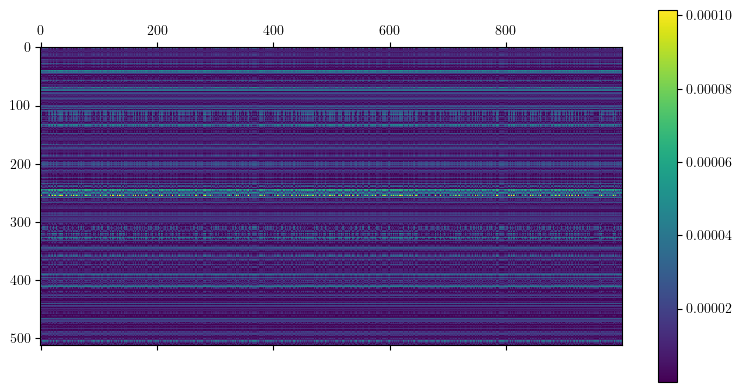

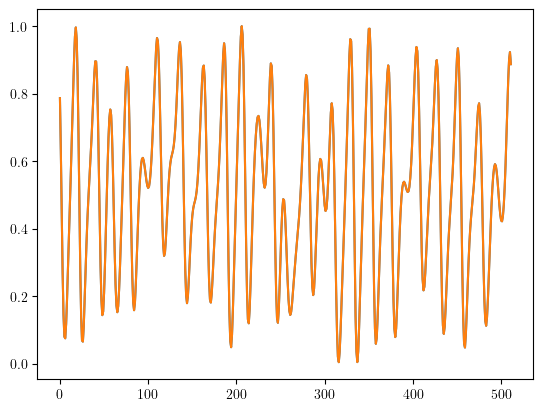

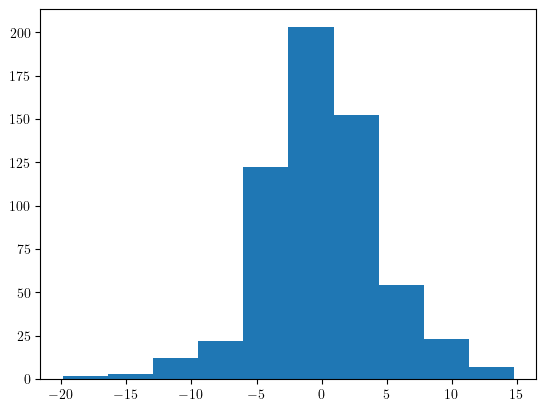

In [46]:
D_all = torch.cat(list(Dataset('ks1d.npy')),dim=0)
D_train = D_all[:21,...] # trains on 20 input-output pairs
D_test = D_all[-2000:,...]
maxval, minval = D_train.max(), D_train.min()
normalize = lambda x: (x-minval)/(maxval-minval)
denormalize = lambda x: x*(maxval-minval)+minval
N = D_train.shape[1]

I = torch.randint(D_test.shape[0]-1,(100,))
X_test = normalize(D_test)[I,:]
Y_test = normalize(D_test)[I+1,:]
errors = []

def cb(k,change,model):
    Y_pred = model(Y_test).detach()
    err = (Y_pred-Y_test).abs().mean()
    errors.append(err)

H = 150 
model = ELM1D(7, 4, H)
model.train([normalize(D_train)], stopping_threshold=1e-3, noise=1e-4, callback=cb)

I = torch.randint(D_train.shape[0]-1,(1000,))
X_test = normalize(D_train)[I,:]
Y_test = normalize(D_train)[I+1,:]
plt.colorbar(plt.matshow((model(X_test).detach()-Y_test).abs().T))
plt.show()

i = torch.argmax((model(X_test).detach()-Y_test).abs().sum(dim=1))
plt.plot(Y_test[i,:].flatten())
plt.plot(model(X_test[i:i+1,:]).detach().flatten())
plt.show()

plt.hist(model.lout.weight.data.view(-1))
plt.show()

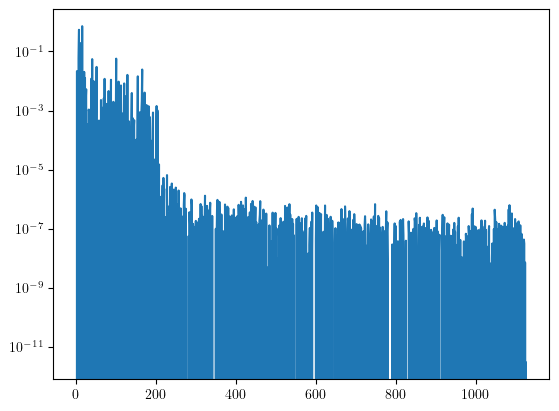

In [47]:
derrors = [errors[i+1]-errors[i] for i in range(len(errors)-1)]
plt.plot(derrors)
plt.yscale("log")
plt.show()

In [48]:
dt = .05
M = D_test.shape[0]

V_pred = torch.empty(M, N, dtype=torch.float64)
V_pred[0,:] = normalize(D_test[0,:])
for i in range(M-1):
    V_pred[i+1,:] = model(V_pred[i,None,:]).detach()
V_pred = denormalize(V_pred)

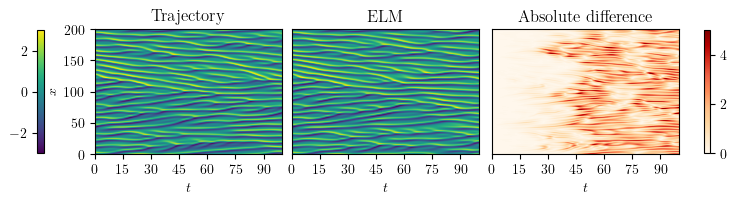

In [57]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

fig = plt.figure(figsize=(10,8)) 
ax = fig.subplots(nrows=1, ncols=3, gridspec_kw={"wspace":.05})

aspect = 1/3
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[0].xaxis.set_major_locator(plt.MultipleLocator(15))
ax[1].xaxis.set_major_locator(plt.MultipleLocator(15))
ax[2].xaxis.set_major_locator(plt.MultipleLocator(15))
im0 = ax[0].imshow(D_test.numpy().T, vmax=3, vmin=-3, aspect=aspect, extent=[0,M*dt,0,200])
im1 = ax[1].imshow(V_pred.numpy().T, vmax=3, vmin=-3, aspect=aspect, extent=[0,M*dt,0,200])
im2 = ax[2].imshow((V_pred-D_test).abs().numpy().T, vmax=5, vmin=0, aspect=aspect, cmap="OrRd", extent=[0,M*dt,0,200])
plt.colorbar(im0, ax=[ax[0],ax[1]], location="left", shrink=0.2, pad=0.1) # fraction=0.036, pad=0.04)
plt.colorbar(im2, ax=[ax[2]], location="right", shrink=0.2, pad=0.1)

ax[0].set_ylabel("$x$")
ax[0].set_xlabel("$t$")
ax[1].set_xlabel("$t$")
ax[2].set_xlabel("$t$")
ax[0].set_title("Trajectory")
ax[1].set_title("ELM")
ax[2].set_title("Absolute difference")

plt.savefig("plots/ks1d.pdf", format="pdf", bbox_inches="tight")
plt.show()